In [110]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from time import time
con = create_engine(os.environ['db_uri'], echo=False).raw_connection()

In [111]:
currency = "EUR"
sql = "select date,currency,rate, extract(dow from date) as dow \
       from rates \
       where \
        currency = %(currency)s \
        and date between %(start)s and %(end)s \
       group by 1, 2, 3, 4"
df = pd.read_sql(sql,con,
                 params={'currency':currency,
                         'start':'2013-01-01',
                         'end':'2017-04-20'},index_col='date',parse_dates=['date'])
df['date'] = df.index

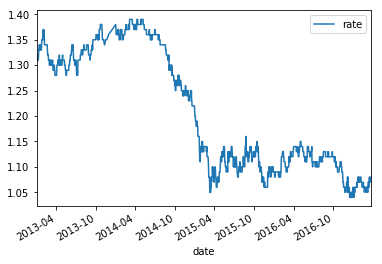

In [112]:
df.plot('date','rate')

In [51]:
df.head()

,currency,rate,dow,date
date,,,,
2016-07-16,EUR,1.10,6.0,2016-07-16
2016-09-17,EUR,1.12,6.0,2016-09-17
2014-10-25,EUR,1.27,6.0,2014-10-25
2016-07-20,EUR,1.10,3.0,2016-07-20
2016-06-30,EUR,1.11,4.0,2016-06-30


In [63]:
df.describe()

,rate,dow
count,1178.000000,1178.000000
mean,1.173294,3.004244
std,0.110461,1.999358
min,1.040000,0.000000
25%,1.100000,1.000000
50%,1.120000,3.000000
75%,1.260000,5.000000
max,1.390000,6.000000


In [70]:
class Dow(BaseEstimator, TransformerMixin):
    def get_feature_names(self):
        return [self.__class__.__name__]
    def fit(self, df, y=None):
        return self
    def transform(self, df):
        df.dropna()
        return df['dow'].as_matrix()[None].T.astype(np.float)
    
feature_list = [
    ('dow',Dow())
]

feat_union = FeatureUnion(transformer_list=feature_list)
X = feat_union.fit_transform(df)
# X = df['date'] #feat_union.fit(df)
# X = X[:, np.newaxis]
Y = np.asarray(df['rate'], dtype="|S6")
model = RandomForestClassifier(n_jobs=2)
model.fit(X,Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [90]:
x = ['2017-03-31']
test_df = pd.DataFrame(data = {'date': ['2017-03-31'], 'currency': 'EUR', 'dow': 6},
                   index=['2017-03-31'])
# test.head()
# df_test = pd.DataFrame(['2017-03-31'],['EUR'],[2],['2017-03-31']
#                         )
X_ts = feat_union.fit_transform(test)
prediction = model.predict_proba(X_ts)
test_df['prediction'] = prediction[:, 4]

In [91]:
test_df.head()

,currency,date,dow,prediction
2017-03-31,EUR,2017-03-31,6,0.040298
